<a href="https://colab.research.google.com/github/dwgb93/TEI_WildfireSpread/blob/main/notebooks/Logistic_Regression_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Next Day Wildfire Spread Dataset: Logistic Regression

*   Parses and normalizes the data into training, validation, and test sets.
*   Using all the data in the training set (other than where the output is knonwn), trains a basic Logistic Regression model
*   Reports which features contributed most to the model
*   Measures the Precision, Recall, and AUC (PR) on new data
*   Plots the metrics and visualizes predictions

Import the required libraries.

In [2]:
import pandas as pd

import sys
import os
import re
from typing import Dict, List, Optional, Text, Tuple
import matplotlib.pyplot as plt
from matplotlib import colors

# Add the project root directory (FireNet) to the Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..')) 
sys.path.append(project_root)

import tensorflow as tf
# from tfrecord.torch.dataset import TFRecordDataset
from torch.utils.data import DataLoader
import numpy as np
from firenet.config import *

2025-03-01 22:56:21.858 | INFO     | firenet.config:<module>:11 - PROJ_ROOT path is: /Users/jess/uoft/Year3/ECE324 Machine Intelligence, Software and Neural Networks/FireNet


In [14]:
# file path on local device
file_path = NDWS_RAW_DATA_DIR

## General functions to load data

In [4]:
# Constants for the data reader

INPUT_FEATURES = ['elevation', 'th', 'vs',  'tmmn', 'tmmx', 'sph',
                  'pr', 'pdsi', 'NDVI', 'population', 'erc', 'PrevFireMask']

OUTPUT_FEATURES = ['FireMask']

# Data statistics
# For each variable, the statistics are ordered in the form:
# (min_clip, max_clip, mean, std)
# I recalculated the statistics based on the the uncropped training data
DATA_STATS = {
    # 0.1 percentile, 99.9 percentile
    # Elevation
    'elevation' : (0.0, 3536.0, 896.5714, 842.6101),
    # Drought index - this claimed to be pressure, but it's Palmer Drought Severity Index
    # https://en.wikipedia.org/wiki/Palmer_drought_index
    # 0.1 percentile, 99.9 percentile
    'pdsi' : (-6.0559, 6.7432, -0.7729, 2.4407),
    # Normalized Difference Vegetation Index https://gisgeography.com/ndvi-normalized-difference-vegetation-index/
    'NDVI' : (-3826.0, 9282.0, 5350.6865, 2185.2192),
    # Precipitation in mm.
    # Negative values make no sense, so min is set to 0.
    # 0., 99.9 percentile
    'pr': (0.0, 19.2422, 0.3234289, 1.5336641),
    # Specific humidity ranges from 0 to 100%.
    'sph': (0., 1., 0.0065263123, 0.003735537), #max changed to 1
    # Wind direction - degrees clockwise from north.
    # Thus min set to 0 and max set to 360.
    'th' : (0.0, 360.0, 146.6468, 3435.0725),
    # Min/max temperature in Kelvin.
    # -20 degree C, 99.9 percentile
    'tmmn' : (253.15, 299.6313, 281.85196, 18.4972), #min changed
    # -20 degree C, 99.9 percentile
    'tmmx' : (253.15, 317.3869, 297.71643, 19.4581), #min changed
    # Wind speed.
    # Negative values do not make sense, given there is a wind direction.
    # 0., 99.9 percentile
    'vs' : (0.0, 9.7368, 3.6278, 1.3092),
    # NFDRS fire danger index energy release component expressed in BTU's per
    # square foot.
    # Negative values do not make sense. Thus min set to zero.
    # 0., 99.9 percentile
    'erc' : (0.0, 109.9254, 53.4690, 25.0980),
    # Population
    # min, 99.9 percentile
    'population' : (0.0, 2935.7548828125, 30.4603, 214.20015),
    # We don't want to normalize the FireMasks.
    'PrevFireMask': (-1., 1., 0., 1.),
    'FireMask': (-1., 1., 0., 1.)
}

In [5]:
"""Library of common functions used in deep learning neural networks.
"""
def random_crop_input_and_output_images(
    input_img: tf.Tensor,
    output_img: tf.Tensor,
    sample_size: int,
    num_in_channels: int,
    num_out_channels: int,
) -> Tuple[tf.Tensor, tf.Tensor]:
  """Randomly axis-align crop input and output image tensors.

  Args:
    input_img: Tensor with dimensions HWC.
    output_img: Tensor with dimensions HWC.
    sample_size: Side length (square) to crop to.
    num_in_channels: Number of channels in `input_img`.
    num_out_channels: Number of channels in `output_img`.
  Returns:
    input_img: Tensor with dimensions HWC.
    output_img: Tensor with dimensions HWC.
  """
  combined = tf.concat([input_img, output_img], axis=2)
  combined = tf.image.random_crop(
      combined,
      [sample_size, sample_size, num_in_channels + num_out_channels])
  input_img = combined[:, :, 0:num_in_channels]
  output_img = combined[:, :, -num_out_channels:]
  return input_img, output_img


def center_crop_input_and_output_images(
    input_img: tf.Tensor,
    output_img: tf.Tensor,
    sample_size: int,
) -> Tuple[tf.Tensor, tf.Tensor]:
  """Calls `tf.image.central_crop` on input and output image tensors.

  Args:
    input_img: Tensor with dimensions HWC.
    output_img: Tensor with dimensions HWC.
    sample_size: Side length (square) to crop to.
  Returns:
    input_img: Tensor with dimensions HWC.
    output_img: Tensor with dimensions HWC.
  """
  central_fraction = sample_size / input_img.shape[0]
  input_img = tf.image.central_crop(input_img, central_fraction)
  output_img = tf.image.central_crop(output_img, central_fraction)
  return input_img, output_img

In [6]:
"""Dataset reader for Earth Engine data."""

def _get_base_key(key: Text) -> Text:
  """Extracts the base key from the provided key.

  Earth Engine exports TFRecords containing each data variable with its
  corresponding variable name. In the case of time sequences, the name of the
  data variable is of the form 'variable_1', 'variable_2', ..., 'variable_n',
  where 'variable' is the name of the variable, and n the number of elements
  in the time sequence. Extracting the base key ensures that each step of the
  time sequence goes through the same normalization steps.
  The base key obeys the following naming pattern: '([a-zA-Z]+)'
  For instance, for an input key 'variable_1', this function returns 'variable'.
  For an input key 'variable', this function simply returns 'variable'.

  Args:
    key: Input key.

  Returns:
    The corresponding base key.

  Raises:
    ValueError when `key` does not match the expected pattern.
  """
  match = re.match(r'([a-zA-Z]+)', key)
  if match:
    return match.group(1)
  raise ValueError(
      'The provided key does not match the expected pattern: {}'.format(key))


def _clip_and_rescale(inputs: tf.Tensor, key: Text) -> tf.Tensor:
  """Clips and rescales inputs with the stats corresponding to `key`.

  Args:
    inputs: Inputs to clip and rescale.
    key: Key describing the inputs.

  Returns:
    Clipped and rescaled input.

  Raises:
    ValueError if there are no data statistics available for `key`.
  """
  base_key = _get_base_key(key)
  if base_key not in DATA_STATS:
    raise ValueError(
        'No data statistics available for the requested key: {}.'.format(key))
  min_val, max_val, _, _ = DATA_STATS[base_key]
  inputs = tf.clip_by_value(inputs, min_val, max_val)
  return tf.math.divide_no_nan((inputs - min_val), (max_val - min_val))


def _clip_and_normalize(inputs: tf.Tensor, key: Text) -> tf.Tensor:
  """Clips and normalizes inputs with the stats corresponding to `key`.

  Args:
    inputs: Inputs to clip and normalize.
    key: Key describing the inputs.

  Returns:
    Clipped and normalized input.

  Raises:
    ValueError if there are no data statistics available for `key`.
  """
  base_key = _get_base_key(key)
  if base_key not in DATA_STATS:
    raise ValueError(
        'No data statistics available for the requested key: {}.'.format(key))
  min_val, max_val, mean, std = DATA_STATS[base_key]
  inputs = tf.clip_by_value(inputs, min_val, max_val)
  inputs = inputs - mean
  return tf.math.divide_no_nan(inputs, std)

def _get_features_dict(
    sample_size: int,
    features: List[Text],
) -> Dict[Text, tf.io.FixedLenFeature]:
  """Creates a features dictionary for TensorFlow IO.

  Args:
    sample_size: Size of the input tiles (square).
    features: List of feature names.

  Returns:
    A features dictionary for TensorFlow IO.
  """
  sample_shape = [sample_size, sample_size]
  features = set(features)
  columns = [
      tf.io.FixedLenFeature(shape=sample_shape, dtype=tf.float32)
      for _ in features
  ]
  return dict(zip(features, columns))


def _parse_fn(
    example_proto: tf.train.Example, data_size: int, sample_size: int,
    num_in_channels: int, clip_and_normalize: bool,
    clip_and_rescale: bool, random_crop: bool, center_crop: bool,
) -> Tuple[tf.Tensor, tf.Tensor]:
  """Reads a serialized example.

  Args:
    example_proto: A TensorFlow example protobuf.
    data_size: Size of tiles (square) as read from input files.
    sample_size: Size the tiles (square) when input into the model.
    num_in_channels: Number of input channels.
    clip_and_normalize: True if the data should be clipped and normalized.
    clip_and_rescale: True if the data should be clipped and rescaled.
    random_crop: True if the data should be randomly cropped.
    center_crop: True if the data should be cropped in the center.

  Returns:
    (input_img, output_img) tuple of inputs and outputs to the ML model.
  """
  if (random_crop and center_crop):
    raise ValueError('Cannot have both random_crop and center_crop be True')
  input_features, output_features = INPUT_FEATURES, OUTPUT_FEATURES
  feature_names = input_features + output_features
  features_dict = _get_features_dict(data_size, feature_names)
  features = tf.io.parse_single_example(example_proto, features_dict)

  if clip_and_normalize:
    inputs_list = [
        _clip_and_normalize(features.get(key), key) for key in input_features
    ]
  elif clip_and_rescale:
    inputs_list = [
        _clip_and_rescale(features.get(key), key) for key in input_features
    ]
  else:
    inputs_list = [features.get(key) for key in input_features]
  
  inputs_stacked = tf.stack(inputs_list, axis=0)
  input_img = tf.transpose(inputs_stacked, [1, 2, 0])

  outputs_list = [features.get(key) for key in output_features]
  assert outputs_list, 'outputs_list should not be empty'
  outputs_stacked = tf.stack(outputs_list, axis=0)

  outputs_stacked_shape = outputs_stacked.get_shape().as_list()
  assert len(outputs_stacked.shape) == 3, ('outputs_stacked should be rank 3'
                                            'but dimensions of outputs_stacked'
                                            f' are {outputs_stacked_shape}')
  output_img = tf.transpose(outputs_stacked, [1, 2, 0])

  if random_crop:
    input_img, output_img = random_crop_input_and_output_images(
        input_img, output_img, sample_size, num_in_channels, 1)
  if center_crop:
    input_img, output_img = center_crop_input_and_output_images(
        input_img, output_img, sample_size)
  return input_img, output_img


def get_dataset(file_pattern: Text, data_size: int, sample_size: int,
                batch_size: int, num_in_channels: int, compression_type: Text,
                clip_and_normalize: bool, clip_and_rescale: bool,
                random_crop: bool, center_crop: bool) -> tf.data.Dataset:
  """Gets the dataset from the file pattern.

  Args:
    file_pattern: Input file pattern.
    data_size: Size of tiles (square) as read from input files.
    sample_size: Size the tiles (square) when input into the model.
    batch_size: Batch size.
    num_in_channels: Number of input channels.
    compression_type: Type of compression used for the input files.
    clip_and_normalize: True if the data should be clipped and normalized, False
      otherwise.
    clip_and_rescale: True if the data should be clipped and rescaled, False
      otherwise.
    random_crop: True if the data should be randomly cropped.
    center_crop: True if the data shoulde be cropped in the center.

  Returns:
    A TensorFlow dataset loaded from the input file pattern, with features
    described in the constants, and with the shapes determined from the input
    parameters to this function.
  """
  if (clip_and_normalize and clip_and_rescale):
    raise ValueError('Cannot have both normalize and rescale.')
  dataset = tf.data.Dataset.list_files(file_pattern)
  dataset = dataset.interleave(
      lambda x: tf.data.TFRecordDataset(x, compression_type=compression_type),
      num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  dataset = dataset.map(
      lambda x: _parse_fn(  # pylint: disable=g-long-lambda
          x, data_size, sample_size, num_in_channels, clip_and_normalize,
          clip_and_rescale, random_crop, center_crop),
      num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return dataset

Depending on the cutoff, we could report ~100% precision or 100% accuracy, trading one off for the other. 

This function returns the precision and recall that maximize the F1-score, for consistency.

For certain cutoffs, the precision is undefined, so it is recorded as 0.

In [7]:
def get_metrics(precs, recs):
  f1s = np.nan_to_num(2*np.nan_to_num(precs)*recs/(np.nan_to_num(precs) + recs))
  return precs[np.argmax(f1s)], recs[np.argmax(f1s)]

Define the features in the dataset

In [8]:
TITLES = [
  'Elevation',
  'Wind\ndirection',
  'Wind\nvelocity',
  'Min\ntemp',
  'Max\ntemp',
  'Humidity',
  'Precip',
  'Drought',
  'Vegetation',
  'Population\ndensity',
  'Energy\nrelease\ncomponent',
  'Previous\nfire\nmask',
  'Fire\nmask'
]

# 3. Load the dataset
Stored locally, as defined by firenet.config file

In [15]:
file_pattern = os.path.join(file_path, 'train', '*.tfrecord')
val_file_pattern = os.path.join(file_path, 'eval', '*.tfrecord')
test_file_pattern = os.path.join(file_path, 'test', '*.tfrecord')

Get the training, validation, and testing datasets


We randomly crop the training data, which provides some small amount of randomness to the model each time it's run. Set center_crop = True to force it to be deterministic.

We center crop the images for validation and testing.

In [16]:
dataset = get_dataset(
      file_pattern,
      data_size=64,
      sample_size=32,
      batch_size=14979,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=True,
      clip_and_rescale=False,
      random_crop=True,
      center_crop=False)

valset = get_dataset(
      val_file_pattern,
      data_size=64,
      sample_size=32,
      batch_size=1877,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=True,
      clip_and_rescale=False,
      random_crop=False,
      center_crop=True)

testset = get_dataset(
      test_file_pattern,
      data_size=64,
      sample_size=32,
      batch_size=1877,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=True,
      clip_and_rescale=False,
      random_crop=False,
      center_crop=True)

TF Datasets are loaded lazily, so materialize the first batch of inputs (11 environmental features) and labels (fire mask).


In [17]:
inputs, labels = next(iter(dataset))

inputs_val, labels_val = next(iter(valset))

inputs_test, labels_test = next(iter(testset))

2025-03-01 23:27:04.914664: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:370] TFRecordDataset `buffer_size` is unspecified, default to 262144


Find how much fire is in each file. They should add to be 18,545 which is the total number of fires.


In [18]:
inputs.shape

TensorShape([14979, 32, 32, 12])

In [19]:
inputs_val.shape

TensorShape([1877, 32, 32, 12])

In [20]:
inputs_test.shape

TensorShape([1689, 32, 32, 12])

# 4. Logistic Regression

In [ ]:
## import LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

Reshape the data in the next two cells to remove "no data" files


In [23]:
X_train = tf.reshape(inputs, [-1,12]).numpy() #len(inputs)*32*32,12
y_train = tf.reshape(labels, [-1]).numpy() #len(labels)*32*32

X_val = tf.reshape(inputs_val, [-1,12]).numpy() 
y_val = tf.reshape(labels_val, [-1]).numpy() 

X_test = tf.reshape(inputs_test, [-1,12]).numpy() 
y_test = tf.reshape(labels_test, [-1]).numpy() 

In [ ]:
#Don't bother learning where no-data is during training.
#makes training quicker and binary
X = X_train[np.where(y_train >= 0)]
y = y_train[np.where(y_train >= 0)]

Set up Logistic Regression model

In [27]:
log_reg = LogisticRegression(penalty = None)


log_reg.fit(X,y)

LogisticRegression(penalty=None)

Create a pandas dataframe to find the important features of this model

Note: Negative values are a negative correlation, but still are important.

For example, as population density increases, the likelyhood of fire spreading there decreases.

In [28]:
score_df = pd.DataFrame({'feature':TITLES[:-1],
                            'importance_score': np.abs(log_reg.coef_[-1]),
                            'actual_value': log_reg.coef_[-1]})

score_df.sort_values('importance_score',ascending=False)

,feature,importance_score,actual_value
11,Previous\nfire\nmask,3.054717,3.054717
3,Min\ntemp,0.759569,0.759569
10,Energy\nrelease\ncomponent,0.334766,0.334766
9,Population\ndensity,0.288098,-0.288098
0,Elevation,0.176412,0.176412
6,Precip,0.140262,-0.140262
7,Drought,0.133444,-0.133444
4,Max\ntemp,0.127837,-0.127837
2,Wind\nvelocity,0.073802,0.073802
1,Wind\ndirection,0.057531,0.057531


# 5. Metrics: Precision, Recall, AUC (PR)

This section of code takes the predictions and labels, and returns a bunch of metrics.

In order to run it, you have to specifiy whether you want the metrics for the training data, validation data, or test data.

To start, import the confusion matrix so we can get the actual fires and predicted fires

Remove "no fire" data in the validation/test data (uncomment one or none for training)

In [30]:
#Leave these commented if you want the training accuracy
#Uncomment one or the other if you want the val/test data
# X, y = X_val, y_val
# X, y = X_test, y_test


#Don't bother learning where no-data is during training.
#makes training quicker and binary (thank fuck)
X = X[np.where(y >= 0)]
y = y[np.where(y >= 0)]

The probability of there being fire



In [31]:
#We just want the probability of being fire
y_pred = log_reg.predict_proba(X)[:,-1]

Get the actual fire and predicted fire values



In [32]:
## just like mse, actual then prediction
cum = confusion_matrix(y, np.round(y_pred))
cum

array([[14608600,    15520],
       [  366924,    10055]])

Get the True Negative (TN), False Positive (FP), False Negative (FN), and True Positive (TP)

In [33]:
## Calculate the confusion matrix here

TN = cum[0,0] 
FP = cum[0,1] 
FN = cum[1,0]
TP = cum[1,1]

Get the baseline precision and recall


The baseline precision is with a cutoff of 0.5 (>0.5 means fire and <0.5 means no fire).

This isn't always ideal, as the model regularly predictions regions are on fire with, say 30% confidence.

In [ ]:
## calculate recall and precision here
print("The baseline precision is", 
         np.round(TP/(FP + TP), 4))

print("The baseline recall is", 
         np.round(TP/(FN + TP), 4))


The baseline precision is 0.3932
The baseline recall is 0.0267


So we sweep through all the cutoffs to see which combination of precision/recall is best.

In [35]:
cutoffs = np.arange(0.001,.975,.001)
precs = []
recs = []
y = y.astype(int)

for cutoff in cutoffs:
    TP = (1*(y_pred >= cutoff) & y).sum()
    PP = 1*(y_pred >= cutoff).sum() #predicted positives = # Denominator for precision
    AP = y.sum() #Actual positives # Denominator for recall
    precs.append(TP/PP)
    recs.append(TP/AP)

/var/folders/3j/7bvky4w57ps4z49wkh2l_kx40000gn/T/ipykernel_11577/3053162352.py:10: RuntimeWarning: invalid value encountered in scalar divide
  precs.append(TP/PP)


In [ ]:
prec, rec = get_metrics(precs, recs)

auc = tf.keras.metrics.AUC(curve = 'PR')
auc.update_state(y, y_pred)

print("The best precision is", prec)
print("The best recall is", rec)
print("The auc is", auc.result().numpy())

/var/folders/3j/7bvky4w57ps4z49wkh2l_kx40000gn/T/ipykernel_11577/522883801.py:2: RuntimeWarning: invalid value encountered in divide
  f1s = np.nan_to_num(2*np.nan_to_num(precs)*recs/(np.nan_to_num(precs) + recs))


The best precision is 0.38952778644711944
The best recall is 0.26155303080542947
The auc is 0.16181013


# 6. Plot of Precision/Recall curves

Nothing fancy. Just seeing how they each change as the cutoff changes.

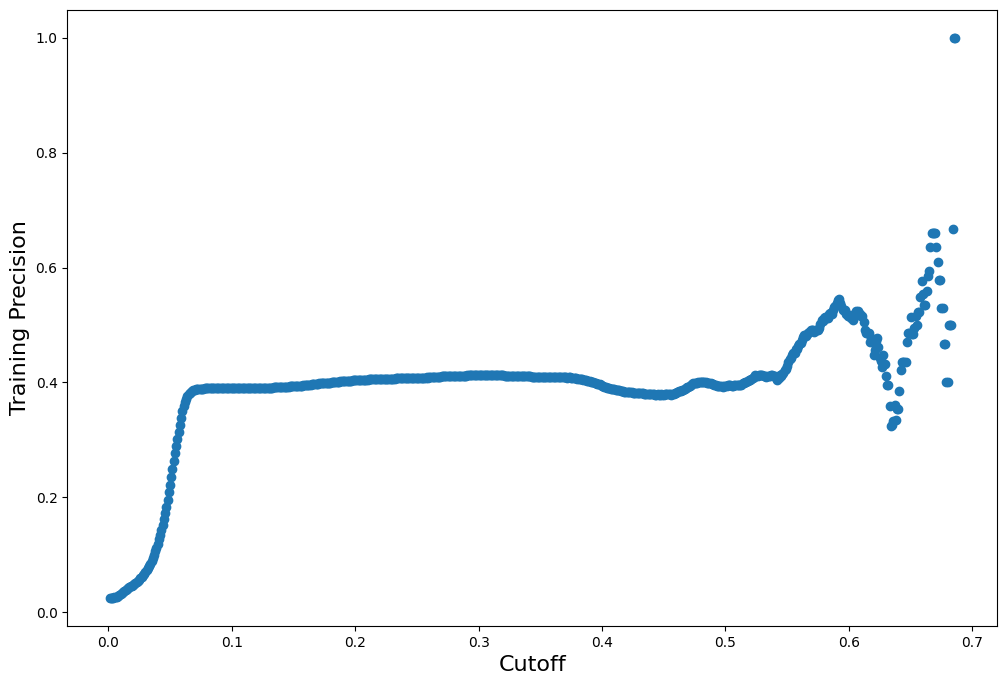

In [37]:
plt.figure(figsize=(12,8))

plt.scatter(cutoffs,precs)

plt.xlabel("Cutoff",fontsize=16)
plt.ylabel("Training Precision",fontsize=16)

plt.show()

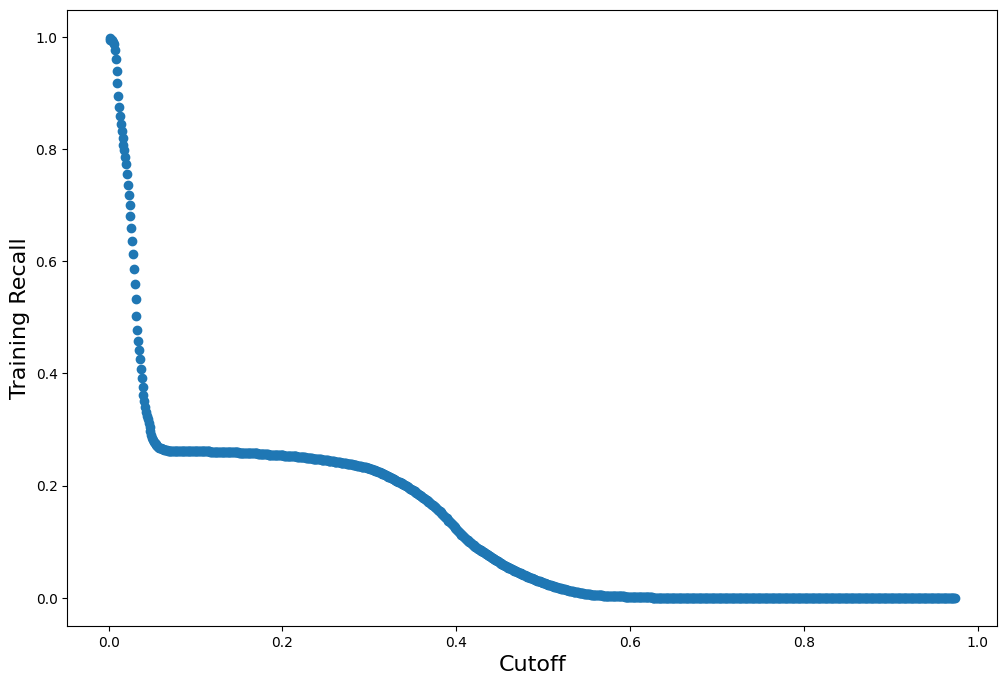

In [38]:
plt.figure(figsize=(12,8))

plt.scatter(cutoffs,recs)

plt.xlabel("Cutoff",fontsize=16)
plt.ylabel("Training Recall",fontsize=16)

plt.show()

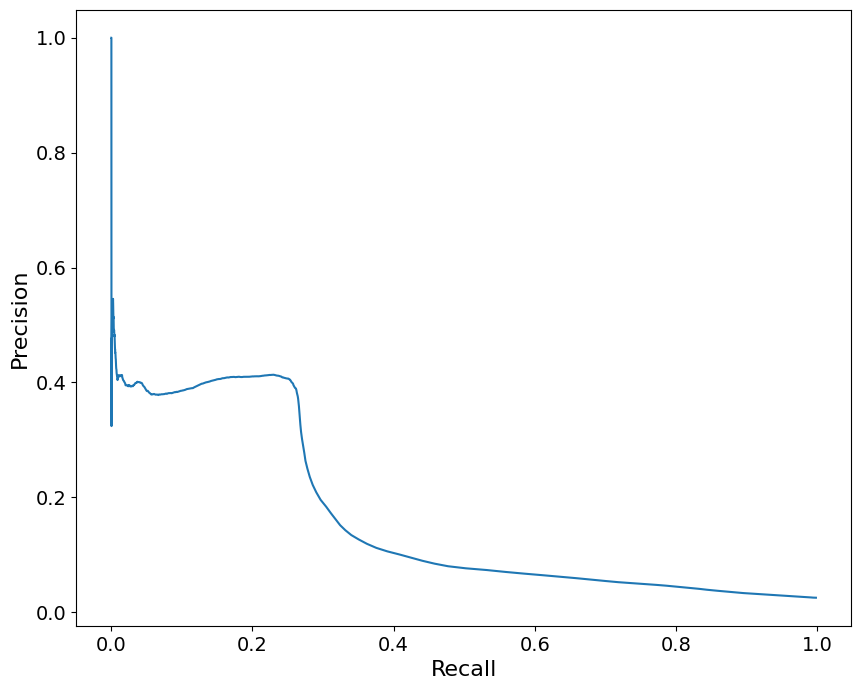

In [39]:
plt.figure(figsize=(10,8))

plt.plot(recs, precs)

plt.xlabel("Recall", fontsize=16)
plt.ylabel("Precision", fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

Remember, we report precision and recall that maximize the F1-score, which usually involves a relatively low threshold for fire.

/var/folders/3j/7bvky4w57ps4z49wkh2l_kx40000gn/T/ipykernel_11577/2028939782.py:3: RuntimeWarning: invalid value encountered in divide
  f1s = np.nan_to_num(2*np.nan_to_num(precs)*recs/(np.nan_to_num(precs) + recs))


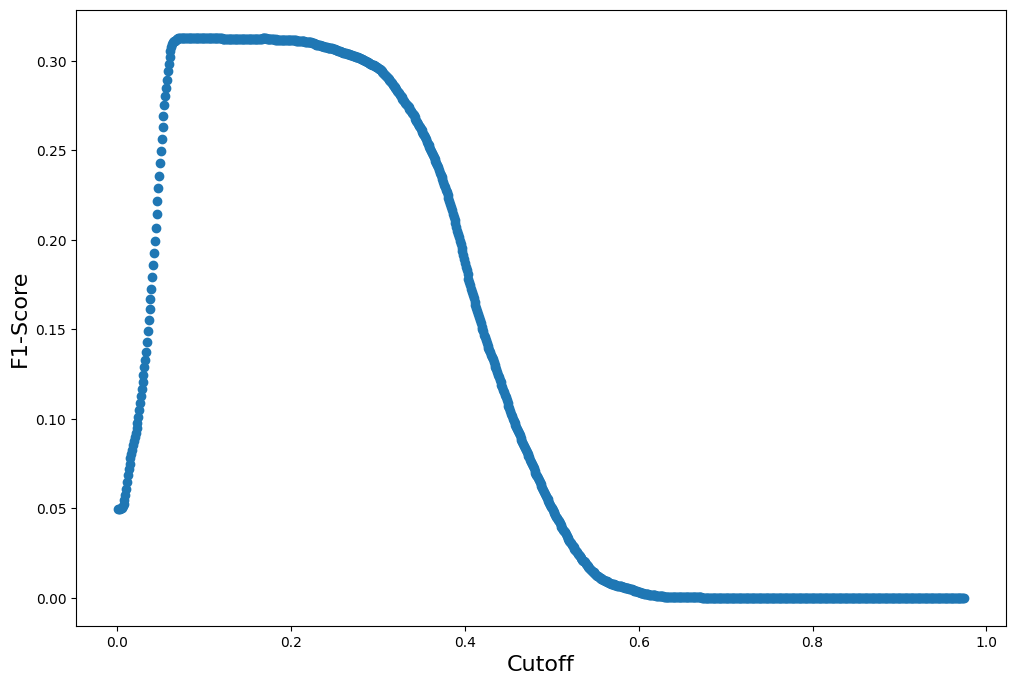

In [40]:
plt.figure(figsize=(12,8))

f1s = np.nan_to_num(2*np.nan_to_num(precs)*recs/(np.nan_to_num(precs) + recs))
plt.scatter(cutoffs,f1s)

plt.xlabel("Cutoff",fontsize=16)
plt.ylabel("F1-Score",fontsize=16)

plt.show()

# 7. Plotting function

Visualize the predicions on a few new inputs

In [41]:
n_rows = 10
n_features = inputs.shape[3]
CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
BOUNDS = [-1, -0.1, 0.001, 1]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)
keys = INPUT_FEATURES

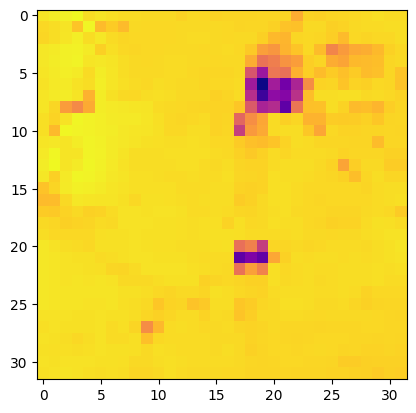

In [42]:
y_pred = log_reg.predict_proba(X_test)[:,-1]
pred = np.reshape(y_pred, (len(inputs_test),32,32))
plt.imshow(pred[0], cmap='plasma') 

Plot the Last fire, Actual fire, and Predicted fire for comparison to see how well this model did in predicting fire.

Note that for inputs with no fire (presumably, it was cropped out), it generally predicts there will be no fire (<2% chance).

For all other inputs, it generally predicts the fire will stay exactly where it is.

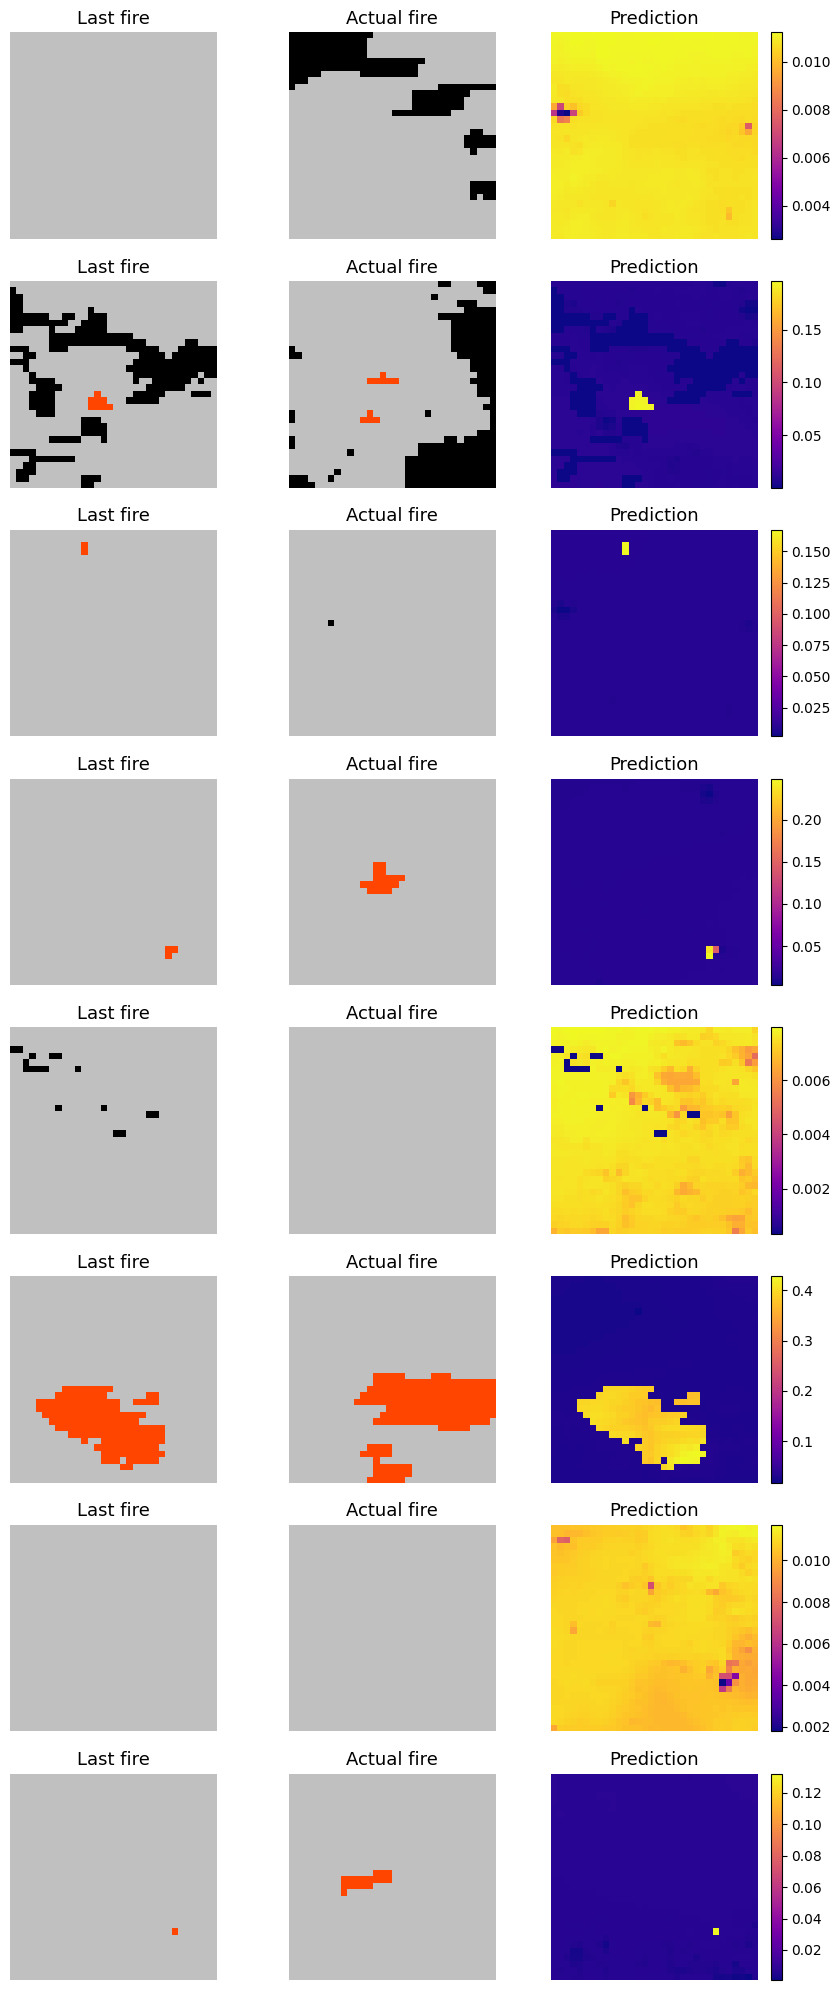

In [43]:
fig = plt.figure(figsize=(9,20))
n_rows = 8

for i in range(n_rows):
  fire_index = i +1000
  plt.subplot(n_rows,3, 3*i + 1)
  plt.title("Last fire", fontsize=13)
  plt.imshow(inputs_test[fire_index, :, :, -1], cmap=CMAP, norm=NORM)
  plt.axis('off')
  plt.subplot(n_rows,3, 3*i + 2)
  plt.title("Actual fire", fontsize=13)
  plt.imshow(labels_test[fire_index, :, :, 0], cmap=CMAP, norm=NORM)
  plt.axis('off')
  plt.subplot(n_rows,3, 3*i + 3)
  plt.title("Prediction", fontsize=13)
  plt.imshow(pred[fire_index], cmap='plasma') 
  plt.colorbar()
  plt.axis('off')
plt.tight_layout()